In [2]:
import pandas as pd
from datetime import datetime

# Đọc dữ liệu
df = pd.read_csv("Data_Number_4.csv", parse_dates=['timestamp'])

# Kiểm tra dữ liệu
print(df.head())


            timestamp   x_coord   y_coord        pm25  temperature  humidity  \
0 2025-04-01 00:00:00  3.745401  3.736408    8.990755         21.5      59.1   
1 2025-04-01 01:00:00  9.507143  3.329121   36.089132         18.0      85.5   
2 2025-04-01 02:00:00  7.319939  1.761539   74.164120         28.3      62.1   
3 2025-04-01 03:00:00  5.986585  6.072667    5.888989         19.9      64.4   
4 2025-04-01 04:00:00  1.560186  4.766242  111.308734         24.1      62.0   

   wind_speed  
0        13.6  
1        25.3  
2         7.7  
3         8.4  
4         2.3  


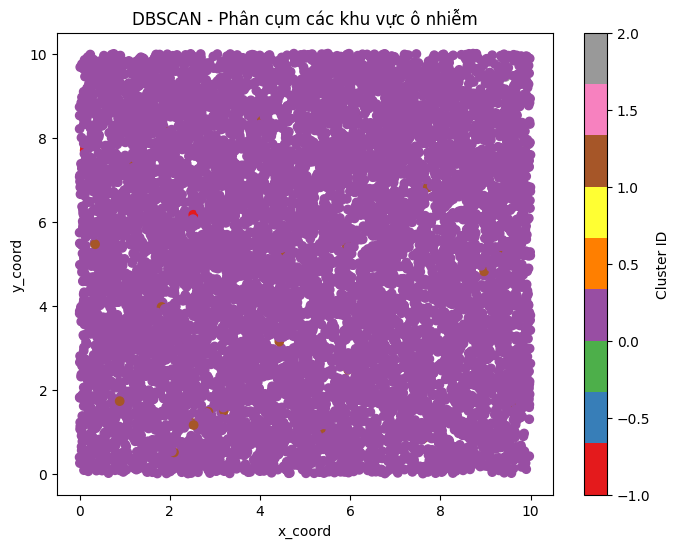

In [3]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Chuẩn hóa dữ liệu (toạ độ và PM2.5)
X = df[['x_coord', 'y_coord', 'pm25']]
X_scaled = StandardScaler().fit_transform(X)

# Áp dụng DBSCAN
db = DBSCAN(eps=0.8, min_samples=2).fit(X_scaled)
df['cluster'] = db.labels_

# Vẽ các cụm
plt.figure(figsize=(8,6))
plt.scatter(df['x_coord'], df['y_coord'], c=df['cluster'], cmap='Set1')
plt.xlabel('x_coord')
plt.ylabel('y_coord')
plt.title('DBSCAN - Phân cụm các khu vực ô nhiễm')
plt.colorbar(label='Cluster ID')
plt.show()


In [4]:
risk_df = df[df['cluster'] != -1].groupby('cluster').agg({
    'pm25': ['mean', lambda x: (x > 50).sum(), 'count']
})

risk_df.columns = ['pm25_mean', 'exceed_count', 'total_count']
risk_df['pollution_risk'] = risk_df['pm25_mean'] * (risk_df['exceed_count'] / risk_df['total_count'])

print(risk_df)


          pm25_mean  exceed_count  total_count  pollution_risk
cluster                                                       
0         31.525979          1789         9965        5.659807
1        298.592765            31           31      298.592765
2        300.000000             2            2      300.000000


In [5]:
df['weather_risk'] = df['humidity'] * (1 / (df['wind_speed'] + 1))


In [6]:
df = df.sort_values('timestamp')
df['pm25_trend'] = df['pm25'].diff()


In [7]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Dùng dữ liệu tại 1 vị trí cụ thể
selected_x, selected_y = df.iloc[0][['x_coord', 'y_coord']]
subset = df[(df['x_coord'] == selected_x) & (df['y_coord'] == selected_y)].copy()

# Nếu không đủ 24 giờ dữ liệu, tạo thêm bằng cách nhân lên (mô phỏng)
while len(subset) < 30:
    subset = pd.concat([subset, subset])

subset = subset.sort_values('timestamp').reset_index(drop=True)

# Dùng các đặc trưng: pm25, temperature, humidity, wind_speed
features = ['pm25', 'temperature', 'humidity', 'wind_speed']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(subset[features])

# Tạo X (24 giờ trước) và y (6 giờ sau)
X_seq, y_seq = [], []
for i in range(len(scaled_data) - 30):
    X_seq.append(scaled_data[i:i+24])
    y_seq.append(scaled_data[i+24:i+30, 0])  # PM2.5 là đặc trưng đầu tiên

X_seq, y_seq = np.array(X_seq), np.array(y_seq)


In [4]:
!pip install keras


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential([
    Input(shape=(24, 4)),
    LSTM(64, return_sequences=False),
    Dense(6)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_seq, y_seq, epochs=100, verbose=0)


NameError: name 'X_seq' is not defined